# Simulation-Based Disaggregation of Education Levels
**Author:** Jiří Landsmann

This notebook demonstrates a simulation-driven pipeline for approximating fine-grained education levels (% of population with higher education) at the district level.

The methodology mirrors the unemployment prediction pipeline, integrating clustering, synthetic label generation, and supervised learning trained on auxiliary household features.


In [38]:
# Education disaggregation based on Kraj-level data using household stats
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

## 1. Data Loading

We load three key datasets:
- **Census data** (`domacnosti.xlsx`) containing auxiliary household features at the district (Okres) level.
- **Regional education summary** (`krajske_vzdelani_percentage_only.xlsx`) providing % of population with higher education at the regional (Kraj) level.
- **Real district-level education data** (`vzdelani_with_percentage_only.xlsx`) used exclusively for final validation.

Datasets are harmonized through consistent naming and preprocessing.


In [39]:
# Load data
krajske_vzdelani = pd.read_excel("./DATA/krajske_vzdelani_percentage_only.xlsx")
okresni_vzdelani = pd.read_excel("./DATA/vzdelani_with_percentage_only.xlsx")
domacnosti = pd.read_excel("./DATA/domacnosti.xlsx")

# Normalize text columns
def normalize_text(series):
    return (
        series.str.lower()
        .str.replace(" ", "")
        .str.normalize("NFKD")
        .str.encode("ascii", errors="ignore")
        .str.decode("utf-8")
    )

# Clean Kraj-level education data
krajske_vzdelani.columns = ["Kraj", "Vyssi_vzdelani"]
krajske_vzdelani["Kraj"] = normalize_text(krajske_vzdelani["Kraj"])

# Clean Okres-level education data
df_okres_real = okresni_vzdelani[~okresni_vzdelani["Unnamed: 0"].str.contains("česká republika", case=False)].copy()
df_okres_real.columns = ["Okres", "Vyssi_vzdelani"]
df_okres_real["Okres"] = normalize_text(df_okres_real["Okres"])

# Clean household data
domacnosti = domacnosti.rename(columns={"region": "Okres"})
domacnosti["Okres"] = normalize_text(domacnosti["Okres"].astype(str))
domacnosti = domacnosti.dropna(subset=["Okres"])

# Filter to Okres-level only (remove "kraj" and "ceskarepublika")
domacnosti_okres = domacnosti[~domacnosti["Okres"].str.contains("kraj|ceskarepublika")].copy()

# Okres to Kraj mapping (manually defined)
okres_to_kraj_map = {
    "hlavnimestopraha": "hlavnimestopraha",
    "benesov": "stredoceskykraj",
    "beroun": "stredoceskykraj",
    "kladno": "stredoceskykraj",
    "kolin": "stredoceskykraj",
    "kutnahora": "stredoceskykraj",
    "melnik": "stredoceskykraj",
    "mladaboleslav": "stredoceskykraj",
    "nymburk": "stredoceskykraj",
    "praha-vychod": "stredoceskykraj",
    "praha-zapad": "stredoceskykraj",
    "pribram": "stredoceskykraj",
    "rakovnik": "stredoceskykraj",
    "ceskebudejovice": "jihoceskykraj",
    "ceskykrumlov": "jihoceskykraj",
    "jindrichuvhradec": "jihoceskykraj",
    "pisek": "jihoceskykraj",
    "prachatice": "jihoceskykraj",
    "strakonice": "jihoceskykraj",
    "tabor": "jihoceskykraj",
    "domazlice": "plzenskykraj",
    "klatovy": "plzenskykraj",
    "plzen": "plzenskykraj",
    "plzen-jih": "plzenskykraj",
    "plzen-mesto": "plzenskykraj",
    "plzen-sever": "plzenskykraj",
    "rokycany": "plzenskykraj",
    "tachov": "plzenskykraj",
    "cheb": "karlovarskykraj",
    "karlovyvary": "karlovarskykraj",
    "sokolov": "karlovarskykraj",
    "decin": "usteckykraj",
    "chomutov": "usteckykraj",
    "litomerice": "usteckykraj",
    "louny": "usteckykraj",
    "most": "usteckykraj",
    "teplice": "usteckykraj",
    "usti": "usteckykraj",
    "ceskalipa": "libereckykraj",
    "jablonecnadnisou": "libereckykraj",
    "liberec": "libereckykraj",
    "semily": "libereckykraj",
    "hradeckralove": "kralovehradeckykraj",
    "jicin": "kralovehradeckykraj",
    "nachod": "kralovehradeckykraj",
    "rychnovnadkneznou": "kralovehradeckykraj",
    "trutnov": "kralovehradeckykraj",
    "chrudim": "pardubickykraj",
    "pardubice": "pardubickykraj",
    "svitavy": "pardubickykraj",
    "ustranadlabem": "pardubickykraj",
    "havlickuvbrod": "krajvysocina",
    "jihlava": "krajvysocina",
    "pelhrimov": "krajvysocina",
    "trebic": "krajvysocina",
    "zdarnadsazavou": "krajvysocina",
    "blansko": "jihomoravskykraj",
    "brno": "jihomoravskykraj",
    "brnomesto": "jihomoravskykraj",
    "brno-venkov": "jihomoravskykraj",
    "breclav": "jihomoravskykraj",
    "hodonin": "jihomoravskykraj",
    "vyskov": "jihomoravskykraj",
    "znojmo": "jihomoravskykraj",
    "jesenik": "olomouckykraj",
    "olomouc": "olomouckykraj",
    "prostejov": "olomouckykraj",
    "prerov": "olomouckykraj",
    "sumperk": "olomouckykraj",
    "bruntal": "moravskoslezskykraj",
    "frydekmistek": "moravskoslezskykraj",
    "karvina": "moravskoslezskykraj",
    "novyjicin": "moravskoslezskykraj",
    "opava": "moravskoslezskykraj",
    "ostrava": "moravskoslezskykraj",
    "ustinadlabem": "usteckykraj",
    "ustinadorlici": "pardubickykraj",
    "brno-mesto": "jihomoravskykraj",
    "kromeriz": "zlinskykraj",
    "uherskehradiste": "zlinskykraj",
    "vsetin": "zlinskykraj",
    "zlin": "zlinskykraj",
    "frydek-mistek": "moravskoslezskykraj",
    "ostrava-mesto": "moravskoslezskykraj",
}

# Assign Kraj to each Okres
domacnosti_okres["Kraj"] = domacnosti_okres["Okres"].map(okres_to_kraj_map)

# Merge with Kraj education level
df = pd.merge(domacnosti_okres, krajske_vzdelani, on="Kraj", how="left")
df = pd.merge(df, df_okres_real, on="Okres", how="left", suffixes=("", "_real"))


## 2. Feature Engineering and Clustering

Household census features are scaled for model input.

Dynamic clustering is applied based on regional variance in education levels:
- Regions with low variance use fewer clusters,
- Regions with higher variance use more clusters to capture internal heterogeneity.

Synthetic district-level education rates are generated while preserving regional aggregates.


In [40]:
# Feature selection
features = df.columns.drop(["Okres", "Kraj", "Vyssi_vzdelani"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Clustering and simulation
df_clustered = []

for kraj in df["Kraj"].dropna().unique():
    subset = df[df["Kraj"] == kraj].copy()
    num_samples = len(subset)
    num_clusters = min(5, num_samples)

    if num_clusters < 2:
        subset["Cluster"] = 0
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        subset["Cluster"] = kmeans.fit_predict(scaler.transform(subset[features]))

    mean_edu = krajske_vzdelani[krajske_vzdelani["Kraj"] == kraj]["Vyssi_vzdelani"].values[0]
    std_dev = mean_edu * 0.1  # Adjusted for education scale

    subset["Simulated_Edu"] = np.random.normal(loc=mean_edu, scale=std_dev, size=len(subset))
    subset["Simulated_Edu"] = subset["Simulated_Edu"].clip(lower=0)

    sim_mean = subset["Simulated_Edu"].mean()
    if sim_mean > 0:
        correction = mean_edu / sim_mean
        subset["Simulated_Edu"] *= correction

    df_clustered.append(subset)

df_clustered = pd.concat(df_clustered)


## 3. Model Training

Four supervised models are trained to predict district-level education percentages:
- Gradient Boosting Regressor
- Random Forest Regressor
- AdaBoost Regressor
- Linear Regression

Models use auxiliary household features and cluster assignments as input predictors.


In [41]:
# Modeling
X_train = df_clustered[features]
y_train = df_clustered["Simulated_Edu"]

models = {
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}

# Fit models and predict
for model_name, model in models.items():
    model.fit(X_train, y_train)
    df_clustered[f"{model_name}_Prediction"] = model.predict(X_train)


## 4. Model Evaluation and Validation

Model predictions are compared to real district-level education percentages.

Evaluation metrics:
- **Mean Absolute Error (MAE)** to quantify prediction error.
- (Optional) Pearson correlation for understanding the predictive alignment.

Baseline results from simulated labels are also evaluated for reference.


In [42]:
# Evaluation
for model_name in models.keys():
    valid_rows = df_clustered[["Vyssi_vzdelani_real", f"{model_name}_Prediction"]].dropna()
    mae = mean_absolute_error(valid_rows["Vyssi_vzdelani_real"], valid_rows[f"{model_name}_Prediction"])
    print(f"{model_name} MAE: {mae:.4f}")

mae_clustering = mean_absolute_error(
    df_clustered["Vyssi_vzdelani_real"],
    df_clustered["Simulated_Edu"]
)
# print(f"Clustering-only MAE: {mae_clustering:.4f}")


GradientBoosting MAE: 2.7516
RandomForest MAE: 2.6933
LinearRegression MAE: 2.3663
DecisionTree MAE: 2.8817


## 5. Saving Detailed Results

The final prediction dataset includes:
- District identifiers
- Cluster assignments
- Simulated education levels
- Model predictions
- Real education percentages

The dataset is saved as `final_education_predictions_with_clusters.csv` for further analysis and visualization.


In [43]:
 # Save predictions
print(df_clustered[[
    "Okres", "Vyssi_vzdelani_real", "Simulated_Edu",
    "GradientBoosting_Prediction", "RandomForest_Prediction",
     "LinearRegression_Prediction",
    "DecisionTree_Prediction"
]])

               Okres  Vyssi_vzdelani_real  Simulated_Edu  \
0   hlavnimestopraha            33.695987      33.695987   
1            benesov            14.341304      17.378931   
2             beroun            16.651104      15.891461   
3             kladno            14.627616      18.439558   
4              kolin            13.654884      17.797517   
..               ...                  ...            ...   
72     frydek-mistek            17.067730      17.524808   
73           karvina            12.339213      14.626793   
74         novyjicin            14.196435      15.302068   
75             opava            15.538760      14.905605   
76     ostrava-mesto            18.584187      16.329691   

    GradientBoosting_Prediction  RandomForest_Prediction  \
0                     33.577875                29.972214   
1                     17.047369                16.712772   
2                     16.406024                16.446224   
3                     17.820090        

In [44]:
# Calculate and store MAEs for education
mae_scores_education = {}

for model_name in models.keys():
    valid_rows = df_clustered[["Vyssi_vzdelani_real", f"{model_name}_Prediction"]].dropna()
    mae = mean_absolute_error(valid_rows["Vyssi_vzdelani_real"], valid_rows[f"{model_name}_Prediction"])
    mae_scores_education[model_name] = mae

# Optional: Also evaluate clustering-only baseline
# valid_clustering = df_clustered[["Vyssi_vzdelani_real", "Simulated_Edu"]].dropna()
# mae_scores_education["Simulated Baseline"] = mean_absolute_error(valid_clustering["Vyssi_vzdelani_real"], valid_clustering["Simulated_Edu"])


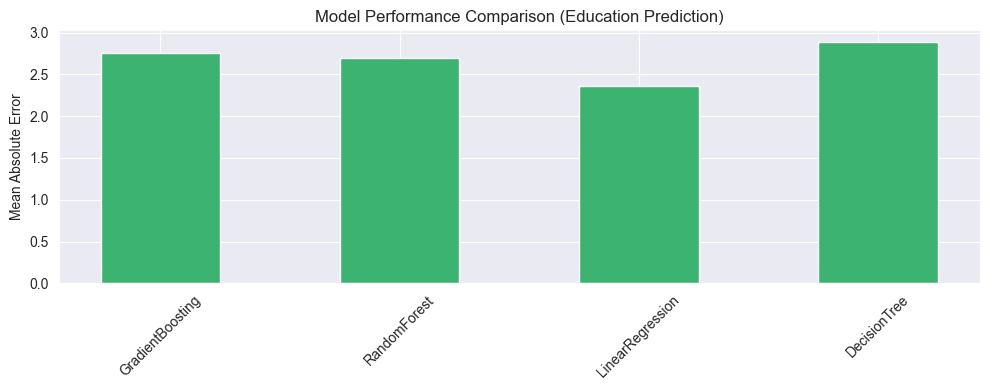

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.bar(mae_scores_education.keys(), mae_scores_education.values(), color='mediumseagreen', width=0.5)
plt.ylabel("Mean Absolute Error")
plt.title("Model Performance Comparison (Education Prediction)")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


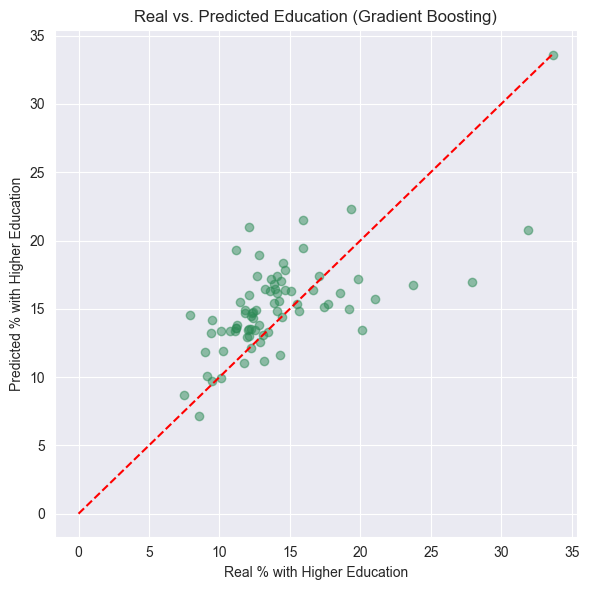

In [46]:
# Scatter plot: Real vs. Predicted (e.g., for GradientBoosting)
plt.figure(figsize=(6,6))
plt.scatter(
    df_clustered["Vyssi_vzdelani_real"], 
    df_clustered["GradientBoosting_Prediction"], 
    alpha=0.5, color='seagreen'
)
plt.plot(
    [0, max(df_clustered["Vyssi_vzdelani_real"])], 
    [0, max(df_clustered["Vyssi_vzdelani_real"])], 
    'r--'
)
plt.xlabel("Real % with Higher Education")
plt.ylabel("Predicted % with Higher Education")
plt.title("Real vs. Predicted Education (Gradient Boosting)")
plt.grid(True)
plt.tight_layout()
plt.show()


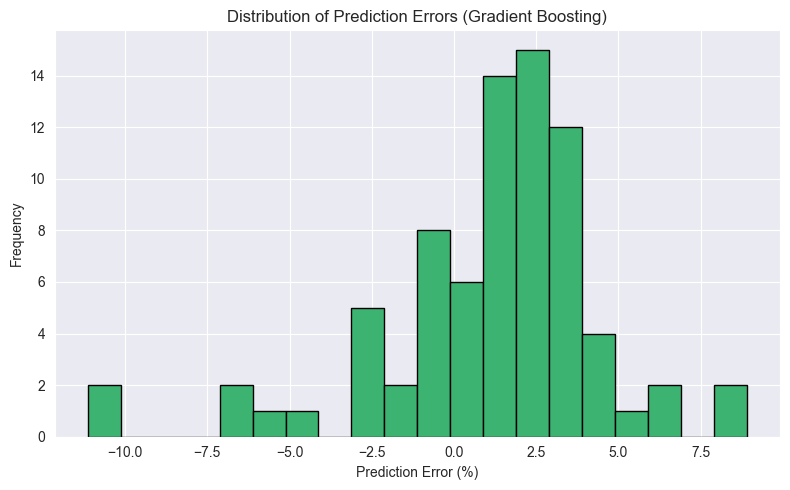

In [47]:
# Error histogram: How wrong are the predictions?
errors_education = df_clustered["GradientBoosting_Prediction"] - df_clustered["Vyssi_vzdelani_real"]

plt.figure(figsize=(8,5))
plt.hist(errors_education, bins=20, color='mediumseagreen', edgecolor='black')
plt.xlabel("Prediction Error (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (Gradient Boosting)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
import pandas as pd

# pokud máš "region" místo "Okres", sjednoť
df_final = df_clustered.rename(columns={"region": "Okres"})

# pokud máš target jinak, přejmenuj si ho na Real_Education
df_final = df_final.rename(columns={
    "% vyšší vzdělání": "Vyssi_vzdelani_real"
    # nebo "Edu_Share": "Real_Education"
})

cols = [
    "Kraj",
    "Okres",
    "Vyssi_vzdelani_real",
    "LinearRegression_Prediction",
    "DecisionTree_Prediction",
    "RandomForest_Prediction",
    "GradientBoosting_Prediction",
]

education_pipeline_csv = "education_pipeline_predictions.csv"

df_final[cols].to_csv(education_pipeline_csv, index=False)
print(f"Saved: {education_pipeline_csv}, rows: {len(df_final)}")


Saved: education_pipeline_predictions.csv, rows: 77


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import r2_score

# Create directories if they don't exist
os.makedirs('plotsMethod', exist_ok=True)

# Read the CSV file
df = pd.read_csv('education_pipeline_predictions.csv')

def safe_r2_score(y_true, y_pred):
    try:
        mask = ~(np.isnan(y_true) | np.isnan(y_pred) | np.isinf(y_true) | np.isinf(y_pred))
        return r2_score(y_true[mask], y_pred[mask])
    except Exception as e:
        print(f"R² calculation error: {e}")
        return np.nan

def plot_prediction_comparison(df, actual_column, predicted_columns,
                                figsize=(20, 10),
                                dpi=300):
    plt.figure(figsize=figsize, dpi=dpi)

    # Create subplots for each model
    for i, (model, predicted_column) in enumerate(predicted_columns.items(), 1):
        plt.subplot(2, 2, i)

        # Remove any potential NaN values
        valid_data = df.dropna(subset=[actual_column, predicted_column])

        # Scatter plot
        plt.scatter(valid_data[actual_column], valid_data[predicted_column],
                    alpha=0.7, s=30)  # Reduced marker size

        # Diagonal line
        min_val = min(valid_data[actual_column].min(), valid_data[predicted_column].min())
        max_val = max(valid_data[actual_column].max(), valid_data[predicted_column].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

        plt.title(f'{model} Method Prediction vs Actual', fontsize=10)
        plt.xlabel('Actual Values', fontsize=8)
        plt.ylabel('Predicted Values', fontsize=8)

        # Calculate metrics
        mae = np.mean(np.abs(valid_data[actual_column] - valid_data[predicted_column]))
        r2 = safe_r2_score(valid_data[actual_column], valid_data[predicted_column])

        plt.annotate(f'MAE: {mae:.2f}\nR²: {r2:.2f}',
                     xy=(0.05, 0.95),
                     xycoords='axes fraction',
                     fontsize=8)

        # Improve tick label readability
        plt.tick_params(axis='both', which='major', labelsize=6)

        # Add grid for better readability
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.savefig(os.path.join('plotsMethod', 'education_method_prediction_comparison.png'),
                dpi=dpi, bbox_inches='tight')
    plt.close()

def plot_error_distribution(df, actual_column, predicted_columns,
                             figsize=(20, 10),
                             dpi=300):
    plt.figure(figsize=figsize, dpi=dpi)

    # Calculate and plot absolute errors
    for i, (model, predicted_column) in enumerate(predicted_columns.items(), 1):
        plt.subplot(2, 2, i)

        # Calculate absolute errors
        abs_errors = np.abs(df[actual_column] - df[predicted_column])

        # Plot error distribution
        sns.histplot(abs_errors, kde=True)

        # Calculate statistical metrics
        mean_error = np.mean(abs_errors)
        median_error = np.median(abs_errors)

        plt.title(f'{model} Absolute Error Distribution', fontsize=10)
        plt.xlabel('Absolute Error', fontsize=8)
        plt.ylabel('Frequency', fontsize=8)

        # Annotate with statistical information
        plt.annotate(f'Mean Error: {mean_error:.2f}\nMedian Error: {median_error:.2f}',
                     xy=(0.05, 0.95),
                     xycoords='axes fraction',
                     fontsize=8,
                     verticalalignment='top')

        # Improve tick label readability
        plt.tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.savefig(os.path.join('plotsMethod', 'education_method_error_distribution.png'),
                dpi=dpi, bbox_inches='tight')
    plt.close()

def print_model_performance(df, actual_column, predicted_columns):
    print("Method Model Performance Summary:")
    for model, predicted_column in predicted_columns.items():
        abs_error = np.abs(df[actual_column] - df[predicted_column])

        print(f"\n{model} Method:")
        print(f"  Mean Absolute Error: {abs_error.mean():.4f}")
        print(f"  Median Absolute Error: {np.median(abs_error):.4f}")
        print(f"  Max Absolute Error: {abs_error.max():.4f}")

        # Calculate R² with error handling
        r2 = safe_r2_score(df[actual_column], df[predicted_column])
        print(f"  R² Score: {r2:.4f}")

# Define predicted columns
predicted_columns = {
    'Linear Regression': 'LinearRegression_Prediction',
    'Decision Tree': 'DecisionTree_Prediction',
    'Random Forest': 'RandomForest_Prediction',
    'Gradient Boosting': 'GradientBoosting_Prediction'
}

# Actual column name
actual_column = 'Vyssi_vzdelani_real'

# Generate plots and analysis
plot_prediction_comparison(df, actual_column, predicted_columns)
plot_error_distribution(df, actual_column, predicted_columns)
print_model_performance(df, actual_column, predicted_columns)

Method Model Performance Summary:

Linear Regression Method:
  Mean Absolute Error: 2.3663
  Median Absolute Error: 1.9652
  Max Absolute Error: 9.5381
  R² Score: 0.5694

Decision Tree Method:
  Mean Absolute Error: 2.8817
  Median Absolute Error: 2.3419
  Max Absolute Error: 11.1436
  R² Score: 0.3467

Random Forest Method:
  Mean Absolute Error: 2.6933
  Median Absolute Error: 2.3715
  Max Absolute Error: 12.0221
  R² Score: 0.4299

Gradient Boosting Method:
  Mean Absolute Error: 2.7516
  Median Absolute Error: 2.3738
  Max Absolute Error: 11.1346
  R² Score: 0.3900
